In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
!rm -rf "/content/DeeplearningUtils"
!git clone https://github.com/atulgupta01/DeeplearningUtils.git

Cloning into 'DeeplearningUtils'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [0]:
tf.enable_eager_execution()

In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [0]:
from DeeplearningUtils.data import data_preProcess_utils
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train,y_train,x_test,y_test = data_preProcess_utils.data_preProcess(x_train,y_train,x_test,y_test)

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
from DeeplearningUtils.data import tf_record_utils
tf_record_utils.save_tf_records(x_train, y_train, './training.tf_records')
tf_record_utils.save_tf_records(x_test, y_test, './testing.tf_records')

In [0]:
from DeeplearningUtils.data import data_augment_utils
eraser = data_augment_utils.get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3,v_l=0.0, v_h=1.0, pixel_level=False)


In [0]:
from DeeplearningUtils.model import model_defn_utils

model = model_defn_utils.DavidNet()

len_train = x_train.shape[0]
len_test = x_test.shape[0]
batches_per_epoch = len_train//BATCH_SIZE + 1


lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(eraser(tf.random_crop(x, [32, 32, 3]))), y)

In [0]:
t = time.time()
test_set = tf_record_utils.load_tf_records_as_dataset('./testing.tf_records',[32,32,3]).batch(BATCH_SIZE)

trainLosses = []
testLosses = []
trainAccuracy = []
testAccuracy = []

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf_record_utils.load_tf_records_as_dataset('./training.tf_records',[40,40,3])
  train_set = train_set.map(data_aug).shuffle(len_train).batch(BATCH_SIZE)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()

  currentTestAcc = (test_acc/len_test) 
  currentTrainAcc = (train_acc/len_train) 
  testAccuracy.append(currentTestAcc)  
  trainAccuracy.append(currentTrainAcc)
  testLosses.append(test_loss / len_test)
  trainLosses.append(train_loss / len_train)
  
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



epoch: 1 lr: 0.08 train loss: 1.6146341369628907 train acc: 0.41546 val loss: 1.2134637817382812 val acc: 0.5691 time: 63.098530292510986



epoch: 2 lr: 0.16 train loss: 0.9128081140136719 train acc: 0.67308 val loss: 0.9062259185791015 val acc: 0.6923 time: 104.58766770362854



epoch: 3 lr: 0.24 train loss: 0.7120005191040039 train acc: 0.75 val loss: 0.6508461196899414 val acc: 0.7708 time: 147.11932706832886



epoch: 4 lr: 0.32 train loss: 0.6238256625366211 train acc: 0.78446 val loss: 0.907554541015625 val acc: 0.7087 time: 189.8042163848877



epoch: 5 lr: 0.4 train loss: 0.5635381344604492 train acc: 0.8046 val loss: 0.6996879806518554 val acc: 0.7832 time: 231.52050399780273



epoch: 6 lr: 0.37894736842105264 train loss: 0.46804300567626955 train acc: 0.83832 val loss: 0.6264878997802734 val acc: 0.7885 time: 273.48660111427307



epoch: 7 lr: 0.35789473684210527 train loss: 0.38969374298095705 train acc: 0.86476 val loss: 0.42812056427001954 val acc: 0.8573 time: 315.14057087898254



epoch: 8 lr: 0.33684210526315794 train loss: 0.339290771484375 train acc: 0.88206 val loss: 0.3810373229980469 val acc: 0.875 time: 356.6150658130646



epoch: 9 lr: 0.31578947368421056 train loss: 0.3028576824951172 train acc: 0.89294 val loss: 0.3510937400817871 val acc: 0.8842 time: 398.1803891658783



epoch: 10 lr: 0.2947368421052632 train loss: 0.27105248901367185 train acc: 0.90396 val loss: 0.3625991485595703 val acc: 0.8773 time: 440.08370304107666



epoch: 11 lr: 0.2736842105263158 train loss: 0.24337194107055665 train acc: 0.91518 val loss: 0.36462841033935545 val acc: 0.8834 time: 481.6512362957001



epoch: 12 lr: 0.25263157894736843 train loss: 0.22149388061523437 train acc: 0.92324 val loss: 0.2922602684020996 val acc: 0.9031 time: 523.3535511493683



epoch: 13 lr: 0.23157894736842108 train loss: 0.19766907768249511 train acc: 0.93106 val loss: 0.2980410179138184 val acc: 0.903 time: 565.1155247688293



epoch: 14 lr: 0.2105263157894737 train loss: 0.1823644300842285 train acc: 0.9364 val loss: 0.3141730712890625 val acc: 0.8977 time: 606.1001358032227



epoch: 15 lr: 0.18947368421052635 train loss: 0.16678981117248534 train acc: 0.94286 val loss: 0.3111192970275879 val acc: 0.9004 time: 647.1204438209534



epoch: 16 lr: 0.16842105263157897 train loss: 0.15029106323242186 train acc: 0.9486 val loss: 0.2757548698425293 val acc: 0.913 time: 688.7924902439117



epoch: 17 lr: 0.1473684210526316 train loss: 0.1339413077545166 train acc: 0.95418 val loss: 0.2447033905029297 val acc: 0.9205 time: 730.2275140285492



epoch: 18 lr: 0.12631578947368421 train loss: 0.12301130859375 train acc: 0.95786 val loss: 0.2809615753173828 val acc: 0.9168 time: 770.9375913143158



epoch: 19 lr: 0.10526315789473689 train loss: 0.109415277633667 train acc: 0.96298 val loss: 0.24235524864196778 val acc: 0.9232 time: 812.2769837379456



epoch: 20 lr: 0.08421052631578951 train loss: 0.09838841957092286 train acc: 0.96734 val loss: 0.2401368698120117 val acc: 0.928 time: 853.155109167099



epoch: 21 lr: 0.06315789473684214 train loss: 0.09228538307189942 train acc: 0.96914 val loss: 0.24232111587524413 val acc: 0.9278 time: 893.5756845474243



epoch: 22 lr: 0.04210526315789476 train loss: 0.08270249687194824 train acc: 0.97272 val loss: 0.22892003479003906 val acc: 0.9293 time: 934.9174244403839



epoch: 23 lr: 0.02105263157894738 train loss: 0.07727818260192872 train acc: 0.97492 val loss: 0.22265412902832032 val acc: 0.9313 time: 976.1638634204865



epoch: 24 lr: 0.0 train loss: 0.07476804531097413 train acc: 0.97588 val loss: 0.22009671249389648 val acc: 0.9329 time: 1016.8443319797516


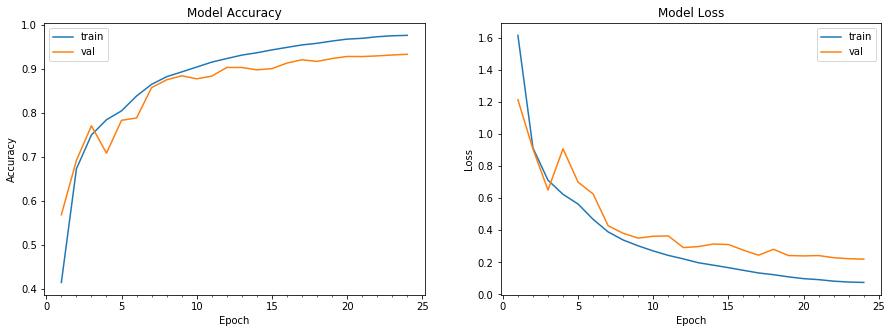

In [0]:
from DeeplearningUtils.model import model_log_plot_utils 
model_log_plot_utils.model_log_plot(trainAccuracy,testAccuracy,trainLosses,testLosses)